In [16]:
import re
import gensim
import logging
import pandas as pd
import urllib.request
from gensim.models import word2vec
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import style
from networkx.algorithms import community

In [2]:
urllib.request.urlretrieve(
    'http://rusvectores.org/static/models/rusvectores2/'
    'ruscorpora_mystem_cbow_300_2_2015.bin.gz',
    'ruscorpora_mystem_cbow_300_2_2015.bin.gz')

('ruscorpora_mystem_cbow_300_2_2015.bin.gz',
 <http.client.HTTPMessage at 0x1b686d2ccc0>)

In [3]:
m = 'ruscorpora_mystem_cbow_300_2_2015.bin.gz'

if m.endswith('.vec.gz'):
    model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=False)
elif m.endswith('.bin.gz'):
    model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=True)
else:
    model = gensim.models.KeyedVectors.load(m)

C:\Users\vital\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [4]:
words = ['любовь_S']

In [7]:
G = nx.Graph()

# список с соседями первого порядка
level_one = []

for word in words:
    if word in model:
        print(word)
        word_part = str(word)[-1:]
        print(word_part)
        #  количество слов-соседей для первого узла
        syn_words = len(model[word])
        for i in model.most_similar(positive=[word], topn=syn_words):
            if i[1] >= 0.5 and str(i[0])[-1:] == word_part:
                level_one.append(i[0])
                G.add_node(i[0], label=str(i[0]))
                G.add_edge(str(word), str(i[0]))
    else:
        print('Увы, слова "%s" нет в модели!' % word)

любовь_S
S


In [8]:
# список с соседями второго порядка
level_two = []
for word in level_one:
    if word in model:
        syn_words = len(model[word])
        for i in model.most_similar(positive=[word], topn=syn_words):
            if i[1] >= 0.5 and str(i[0])[-1:] == word_part:
                level_two.append(i[0])
                G.add_node(i[0], label=str(i[0]))
                G.add_edge(str(word), str(i[0]))
    else:
        print('Увы, слова "%s" нет в модели!' % word)

In [9]:
central = []

# самые центральные узлы графа по degree centrality
deg = nx.degree_centrality(G)
for nodeid in sorted(deg, key=deg.get, reverse=True)[:5]:
    if nodeid not in central:
        central.append(nodeid)
    print(nodeid)

нежность_S
жалость_S
сострадание_S
страсть_S
привязанность_S


In [10]:
# самые центральные узлы графа по eigencentrality
eigen = nx.eigenvector_centrality_numpy(G, weight=100)
for nodeid in sorted(eigen, key=eigen.get, reverse=True)[:5]:
    if nodeid not in central:
        central.append(nodeid)
    print(nodeid)

нежность_S
жалость_S
сострадание_S
привязанность_S
любовь_S


In [11]:
# самые центральные узлы графа по closeness centrality
closeness = nx.closeness_centrality(G)
for nodeid in sorted(closeness, key=closeness.get, reverse=True)[:5]:
    if nodeid not in central:
        central.append(nodeid)
    print(nodeid)

любовь_S
нежность_S
жалость_S
сострадание_S
привязанность_S


In [12]:
# самые центральные узлы графа по betweenness centrality
betweenness = nx.betweenness_centrality(G)
for nodeid in sorted(betweenness, key=betweenness.get, reverse=True)[:5]:
    if nodeid not in central:
        central.append(nodeid)
    print(nodeid)

нежность_S
любовь_S
жалость_S
страсть_S
джалаловна_S


In [13]:
centrals = dict(zip(central, central))

not_central = []
for i in G:
    if i not in centrals:
        not_central.append(i)

not_centrals = dict(zip(not_central, not_central))

In [14]:
print('Плотность графа:')
print(nx.density(G))

print('\nДиаметр графа:')
print(nx.diameter(G))

print('\nРадиус графа:')
print(nx.radius(G))

print('\nКоэффициент кластеризации:')
print(nx.average_clustering(G))
print(nx.transitivity(G))

print('\nКоэффициент ассортативности:')
print(nx.degree_pearson_correlation_coefficient(G))

Плотность графа:
0.03614457831325301

Диаметр графа:
4

Радиус графа:
2

Коэффициент кластеризации:
0.22825573579171285
0.0967741935483871

Коэффициент ассортативности:
-0.5593877956349643


In [19]:
# Делим граф на сообщества
communities_generator = community.girvan_newman(G)
top_level_communities = next(communities_generator)
comm = next(communities_generator)
#sorted(map(sorted, comm))

Первое сообщество: в основном разные степени интерпретации слова любовь как страсть

Второе сообщество: самое многочисленное, в него сходят все существительные, которые не совпадают с семантикой слов из первого сообщества, в том числе большое количество антонимов первоначальному узлу и слов с негативной эмоциональной окраской

Третье сообщество: имена собственные

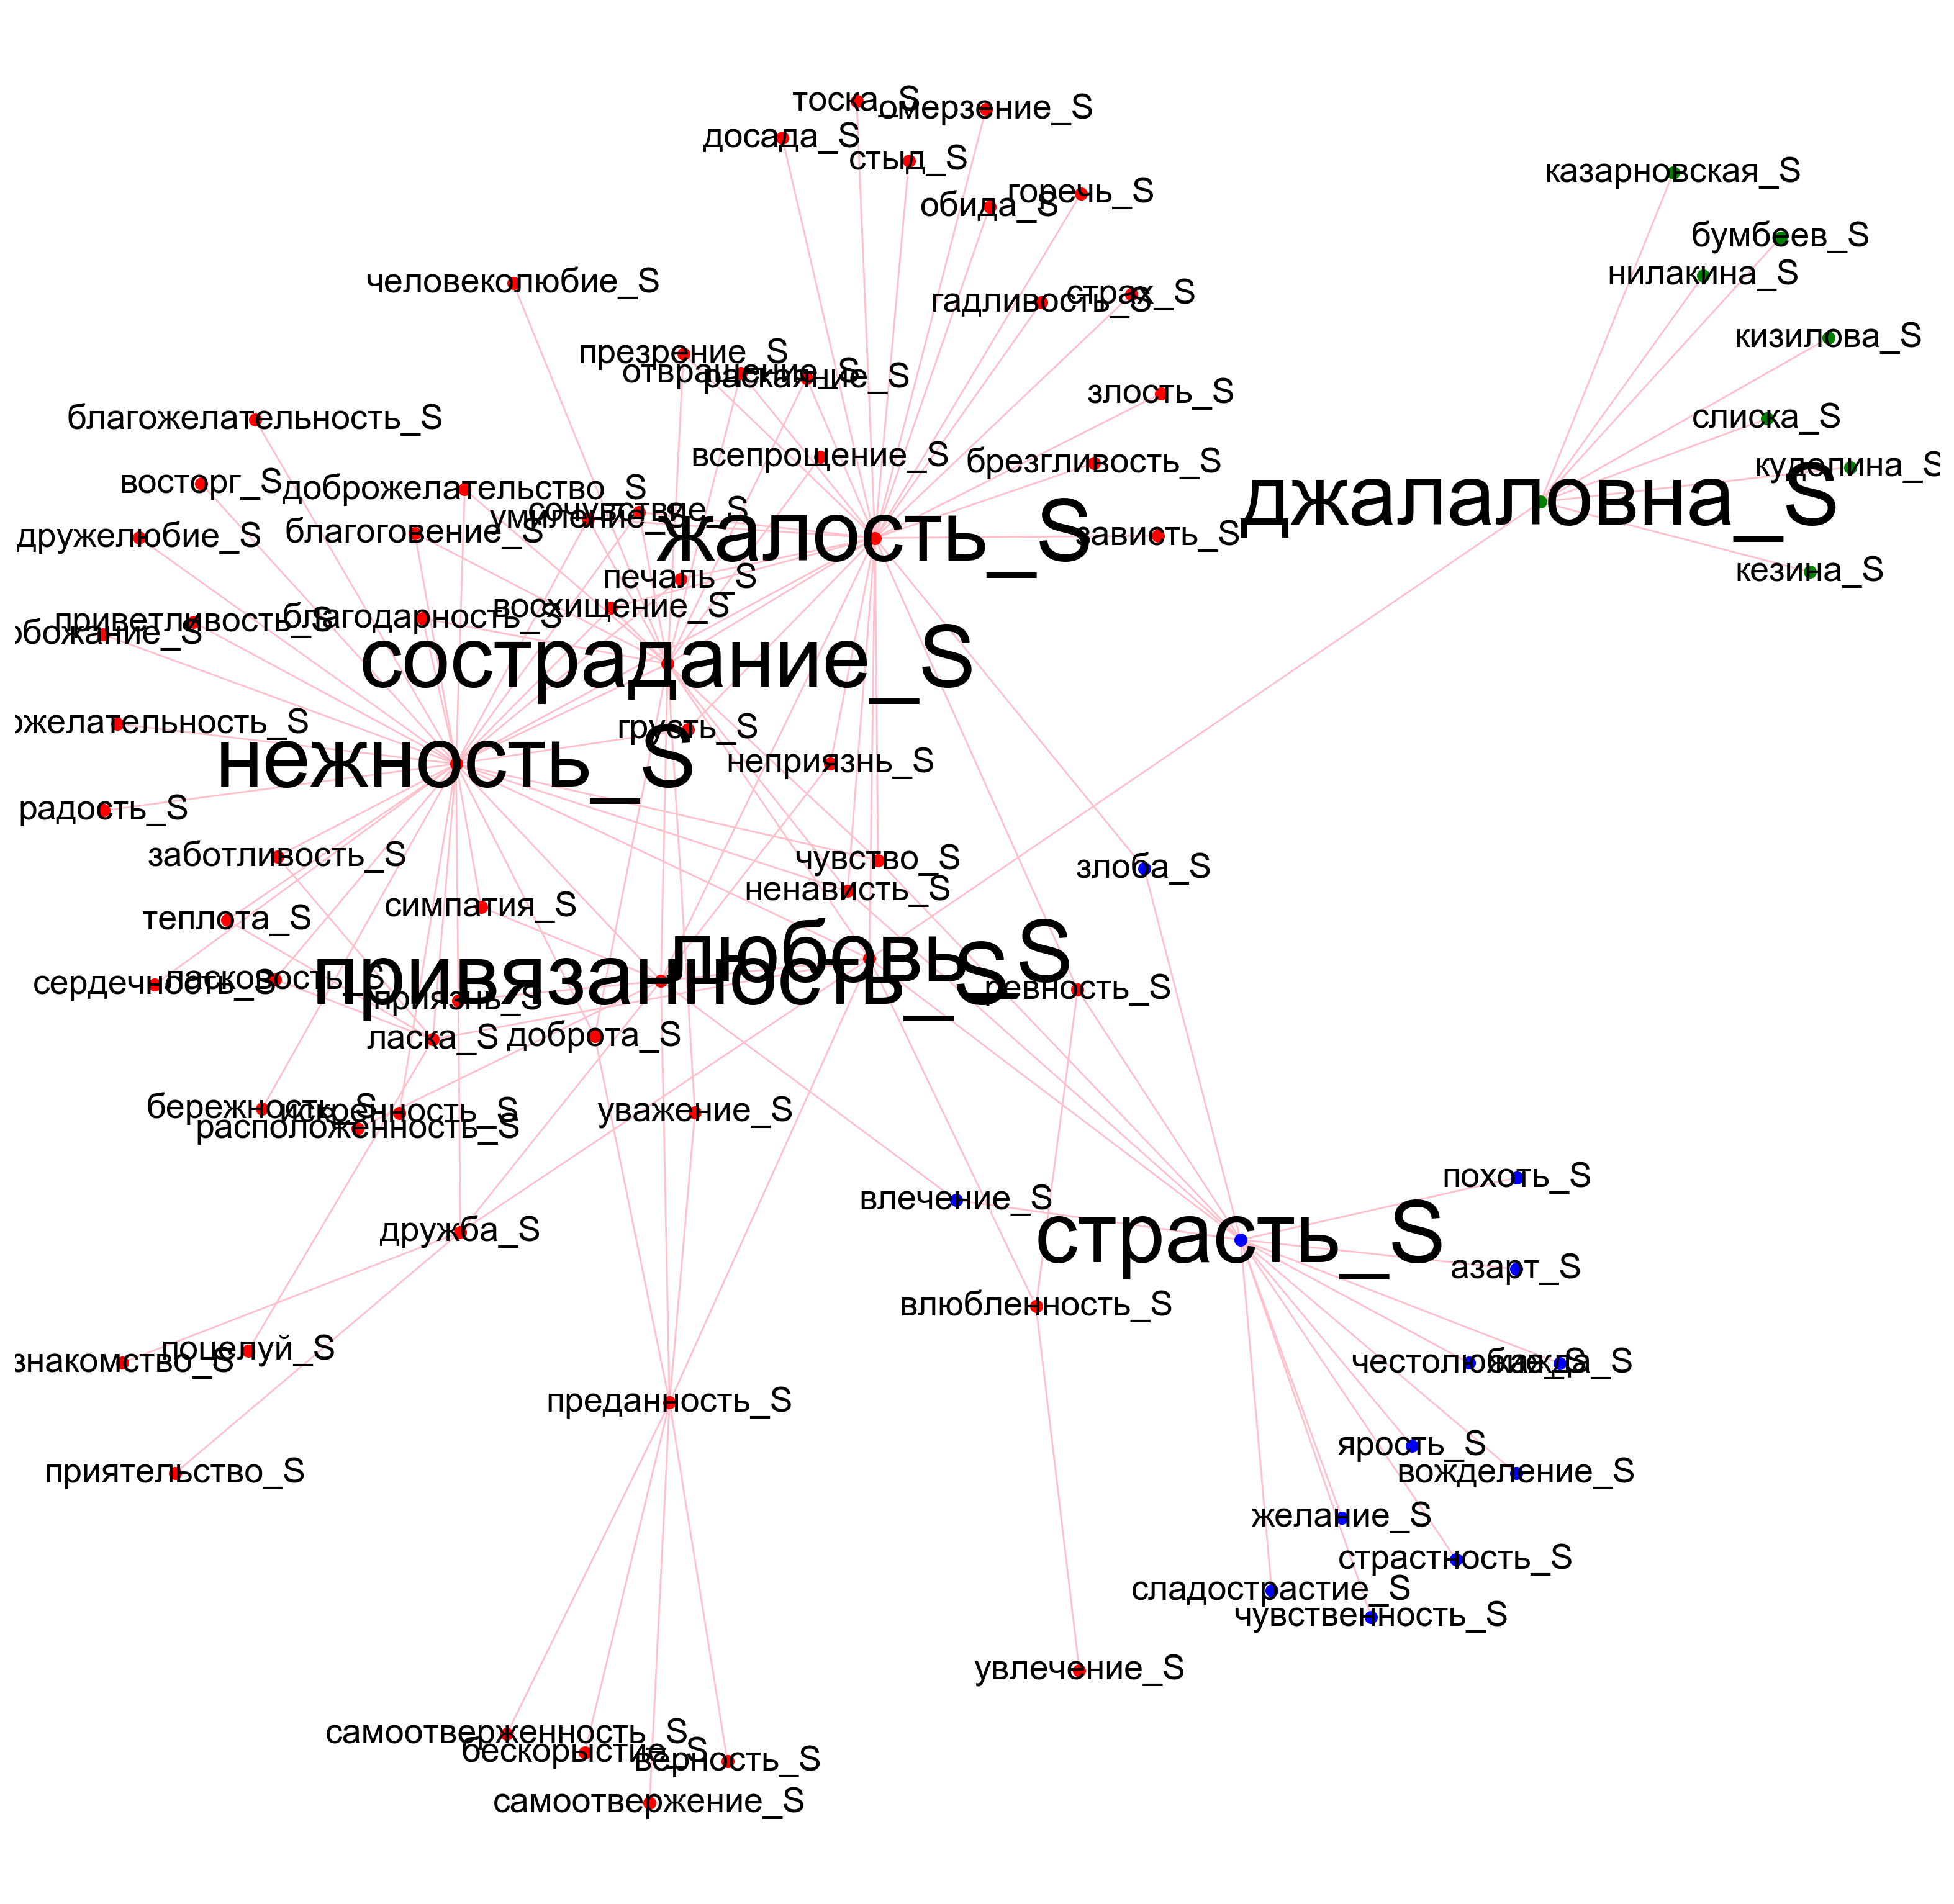

In [18]:
style.use('ggplot')

pos = nx.spring_layout(G)

plt.figure(figsize=(20, 20), dpi=200)

nx.draw_networkx_nodes(G, pos, comm[0], node_color='red', node_size=50)
nx.draw_networkx_nodes(G, pos, comm[1], node_color='blue', node_size=50)
nx.draw_networkx_nodes(G, pos, comm[2], node_color='green', node_size=50)
nx.draw_networkx_edges(G, pos, edge_color='pink')
nx.draw_networkx_labels(
    G, pos, not_centrals, font_size=20, font_family='Arial')
nx.draw_networkx_labels(G, pos, centrals, font_size=50, font_family='Arial')
plt.axis('off')
plt.show()
